In [ ]:
import os 


In [122]:
data_dir = "data/"
import os

failed = []
for fn in os.listdir(data_dir+"tm-seqid"):
    if fn.endswith("DS_Store") or fn.endswith("txt"): continue
    with open("./"+data_dir+"tm-seqid/"+fn) as f:
        print(f.name)
        tm_s = ""
        seq_s = ""
        for i, line in enumerate(f):
            try:
                a, b, tm, seq = line.split()
                tm_s  += "{} {} {}\n".format(a, b, tm)
                seq_s += "{} {} {}\n".format(a, b, seq)
            except ValueError:
                failed.append((fn, line, i))
                continue
            
        with open("./"+data_dir+"tm/"+fn.replace("TM-ID","tm").replace("_","-"),"w") as fout:
            fout.write(tm_s)
        with open("./"+data_dir+"seqid/"+fn.replace("TM-ID","seq").replace("_","-"),"w") as fout:
            fout.write(seq_s)
                
            


./data/tm-seqid/Apoc_lpc_pos-TM-ID.out
./data/tm-seqid/SOIPPA_neg-TM-ID.out
./data/tm-seqid/Apoc-ligsite-pos-TM-ID.out
./data/tm-seqid/hoffman_neg-TM-ID.out
./data/tm-seqid/kahraman_pos-TM-ID.out
./data/tm-seqid/tough-pos-TM-ID.out
./data/tm-seqid/ATP_pos-TM-ID.out
./data/tm-seqid/ITO138_neg-TM-ID.out
./data/tm-seqid/steroid_neg-TM-ID.out
./data/tm-seqid/CYP_neg-TM-ID.out
./data/tm-seqid/huang_neg-TM-ID.out
./data/tm-seqid/Apoc-ligsite-neg-TM-ID.out
./data/tm-seqid/Apoc_lpc_neg-TM-ID.out
./data/tm-seqid/SOIPPA_pos-TM-ID.out
./data/tm-seqid/tough-neg-TM-ID.out
./data/tm-seqid/hoffman_pos-TM-ID.out
./data/tm-seqid/kahraman_neg-TM-ID.out
./data/tm-seqid/steroid_pos-TM-ID.out
./data/tm-seqid/ITO138_pos-TM-ID.out
./data/tm-seqid/ATP_neg-TM-ID.out
./data/tm-seqid/CYP_pos-TM-ID.out
./data/tm-seqid/huang_pos-TM-ID.out


In [131]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc, roc_curve, precision_recall_curve

algs = {}
data_dir = "data/"
for d in os.listdir(data_dir):
    if d.startswith(".") or d.endswith("gz") or d.endswith("txt") or d=="tm-seqid": continue
    algs[d] = dict()
    for f in os.listdir(data_dir + d):
        if f.endswith("DS_Store") or f.endswith("txt") : continue
        pn = 0 if "pos" in f.lower() else 1 if "neg" in f.lower() else None
        if pn is None:
            raise FileNotFoundError("File {} not found".format(f))
        fname = data_dir + d + "/" + f
        s = "_".join(f.split("-")[0:2]).lower() if "apoc" in f.lower() else f.split("-")[0].lower()
        s = "hoffman" if s.lower().startswith("hoff") else s
        
        if not s in algs[d]:
            algs[d][s] = [None, None]
        algs[d][s][pn] = fname

In [178]:

aucs = dict()
rocs = dict()
for alg in algs:
    print(alg)
    rocs[alg] = dict()
    aucs[alg] = dict()
    for dataset in algs[alg]:
        f1 = open(algs[alg][dataset][0]).readlines()
        f2 = open(algs[alg][dataset][1]).readlines()
        
        scores = []
        todel = []
        for i, v in enumerate(f1):
            try:
                scores.append(float(v.split()[-1]))
            except ValueError: todel.append(i)
        f1 = [v for i,v in enumerate(f1) if not i in todel] 
        
        todel = []
        for i, v in enumerate(f2):
            try:
                scores.append(float(v.split()[-1]))
            except ValueError: todel.append(i)
        f2 = [v for i,v in enumerate(f2) if not i in todel]
        
            
        actual = [1]*len(f1) + [0]*len(f2)

        fpr,tpr,thr = roc_curve(actual, scores)
        AUC = auc(fpr,tpr)
        aucs[alg][dataset] = AUC
        rocs[alg][dataset] = (fpr, tpr, thr, actual, scores)

ematchsite
tm
glosa
seqid
volume
pocketalign


In [179]:
import pandas as pd
aucs_df = pd.DataFrame(aucs)
aucs_df

,ematchsite,tm,glosa,seqid,volume,pocketalign
apoc_ligsite,0.888142,0.749094,0.765578,0.749993,0.467545,0.861577
apoc_lpc,0.888142,0.743877,0.902920,0.742628,0.393452,0.974444
atp,0.796213,0.421801,0.711513,0.527644,0.374611,0.827861
cyp,0.747666,0.910502,0.913020,0.928240,0.372138,0.921929
hoffman,0.709484,0.572589,0.599209,0.585089,0.467512,0.601051
huang,0.616432,0.526332,0.563701,0.534687,0.419547,0.620441
ito138,0.748079,0.483662,0.599826,0.560236,0.431149,0.691654
kahraman,0.634519,0.509979,0.487326,0.546112,0.430555,0.510203
soippa,0.810250,0.505964,0.207622,0.594023,0.429761,0.833786
steroid,0.423622,0.681633,0.831566,0.502527,0.548285,0.749267


In [181]:
rocs_df = pd.DataFrame(rocs).T



apoc_ligsite


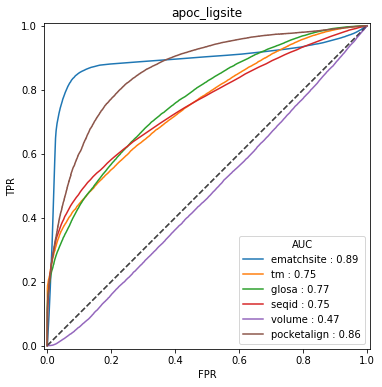

apoc_lpc


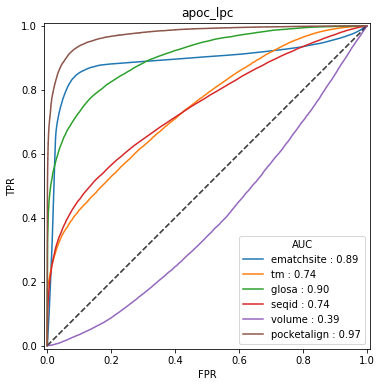

atp


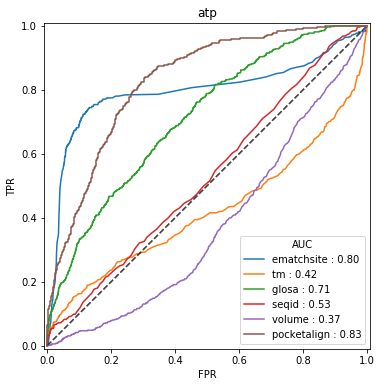

cyp


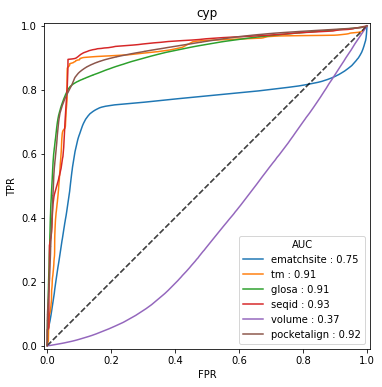

hoffman


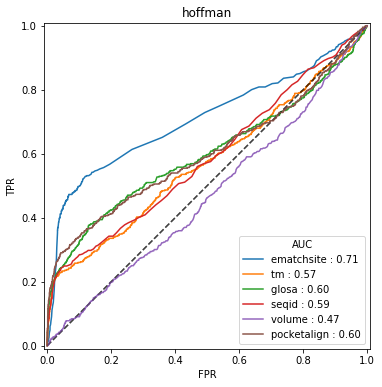

huang


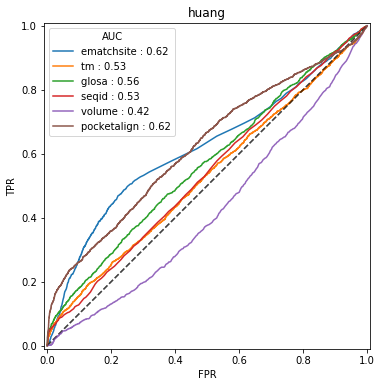

ito138


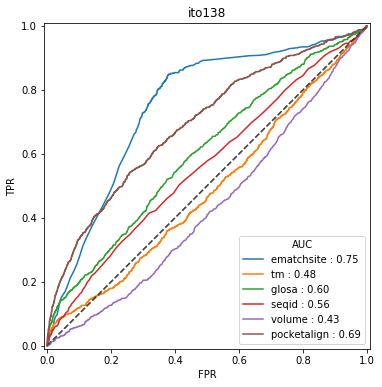

kahraman


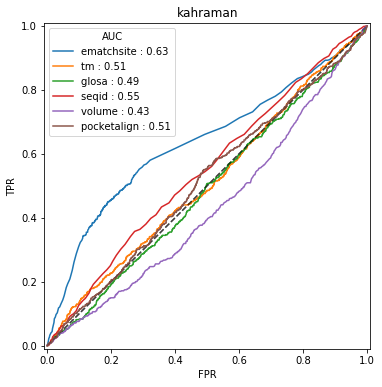

soippa


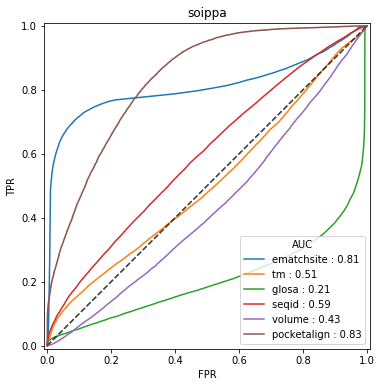

steroid


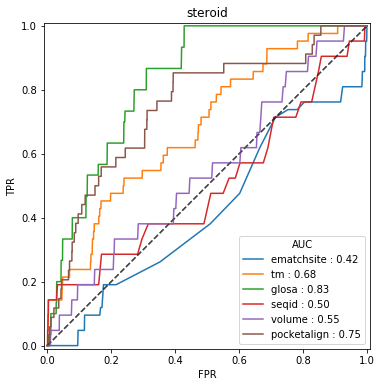

tough


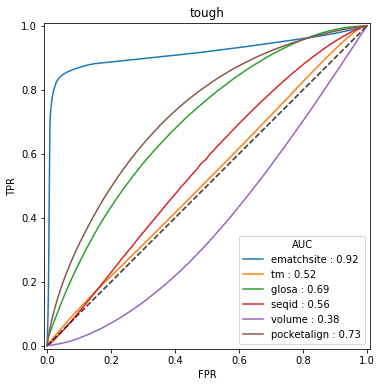

In [182]:
for dataset in rocs_df:
    fig = plt.figure(figsize=(6,6)) # default is (8,6)
    ax = fig.add_subplot(111, aspect='equal')
    for alg,(fpr, tpr, thrs, actual, scores) in zip(rocs_df.index, rocs_df[dataset]):
        AUC = aucs[alg][dataset]
        #proportion = sum(actual)/len(actual)
        ax.plot(fpr,tpr, label=alg+" : %.2f"%(AUC))
        ax.plot(fpr,fpr,"k--",alpha=.2)
        
        ax.set_title(dataset)
        ax.legend(title="AUC")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(-0.01,1.01)
        
    #plt.savefig("%s.png"%dataset)
    print(dataset)
    plt.show()

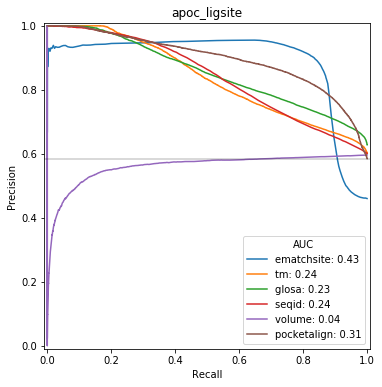

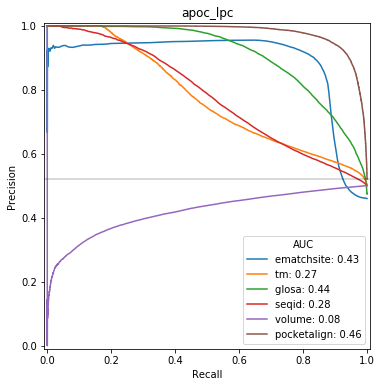

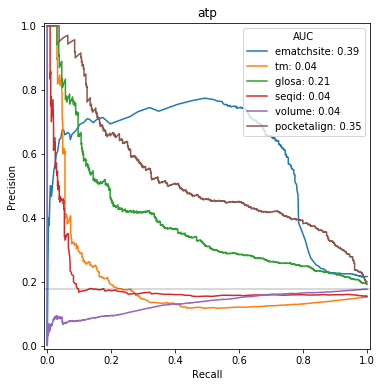

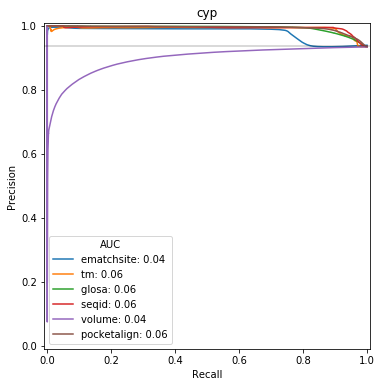

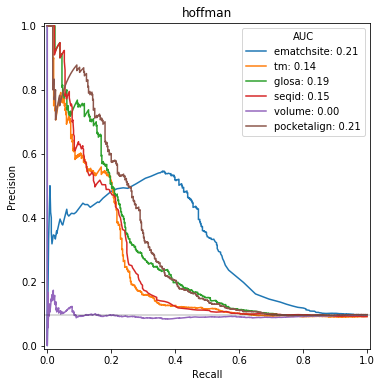

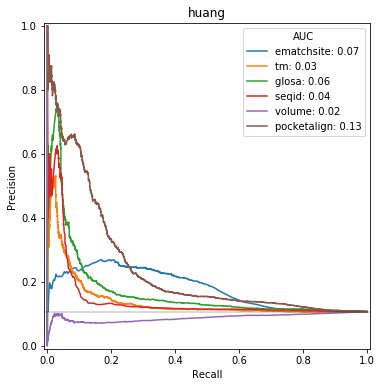

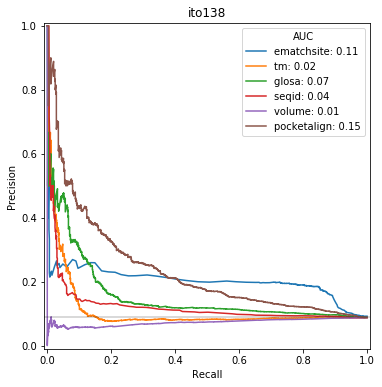

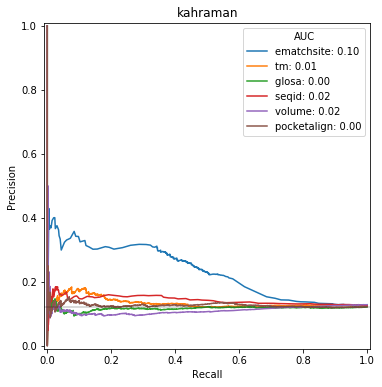

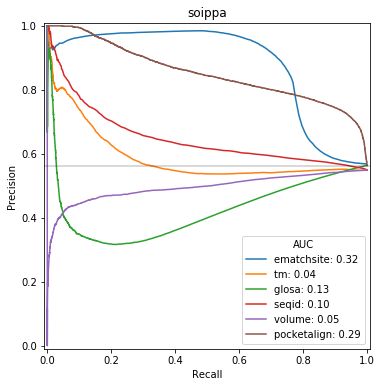

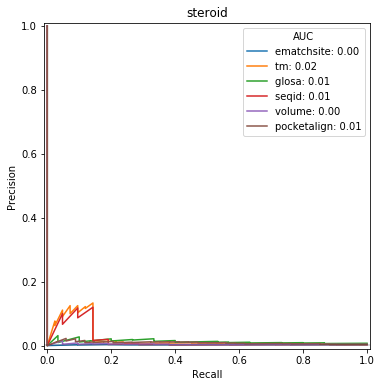

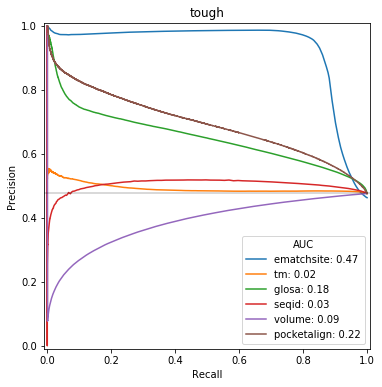

In [186]:
for dataset in rocs_df:
    fig = plt.figure(figsize=(6,6)) # default is (8,6)
    ax = fig.add_subplot(111, aspect='equal')
    for alg,(fpr, tpr, thrs, actual, scores) in zip(rocs_df.index, rocs_df[dataset]):
        pre, rec, thrs = precision_recall_curve(actual, scores)
        proportion = sum(actual)/len(actual)
        
        AUC = np.abs(proportion-auc(rec,pre))
        ax.plot(rec,pre,label=alg+": %.2f"%(AUC))
        
        ax.legend(title="AUC")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(-0.01,1.01)
        ax.set_title(dataset)
        
    ax.axhline(y=proportion,color="k",alpha=.2)
    plt.show()

In [197]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import math

df = aucs_df.copy()

def spider(df, dataset, apply=lambda x: x,save=True):
    # number of variable
    categories = list(df)
    N = len(categories)

    # We need to repeat the first value to close the circular graph:
    values = df.loc[dataset].values.flatten().tolist()
    values += values[:1]

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=8)

    # Draw ylabels
    ax.set_rlabel_position(30)
    plt.yticks([0,.5,.75,1], ["","0.5","0.75","1"], color="grey", size=7)
    plt.ylim(0,1)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.title(dataset)
    
    score = "%.2f"%(sum(values[:-1])/len(values[:-1]))
    #plt.text(10,0,score)
    ax.annotate(score,[math.pi-.01,.075])
    
    if save:
        plt.savefig("./pics/%s.png"%dataset)
    plt.show()




,ematchsite,tm,glosa,seqid,volume,pocketalign
apoc_ligsite,0.944498,0.669721,0.790981,0.581300,0.541636,0.756878
apoc_lpc,0.944498,0.659045,0.985682,0.563999,0.121005,1.000000
atp,0.757581,0.000000,0.714336,0.059002,0.014040,0.684253
cyp,0.658871,1.000000,1.000000,1.000000,0.000000,0.886881
hoffman,0.581237,0.308549,0.555129,0.193939,0.541445,0.195692
huang,0.392038,0.213897,0.504792,0.075546,0.269143,0.237460
ito138,0.659711,0.126584,0.556005,0.135560,0.335013,0.390857
kahraman,0.428814,0.180433,0.396520,0.102381,0.331638,0.000000
soippa,0.786122,0.172218,0.000000,0.214925,0.327133,0.697016
steroid,0.000000,0.531680,0.884528,0.000000,1.000000,0.514957


In [201]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df)
df_normalized = pd.DataFrame(np_scaled)
df_normalized.index = df.index
df_normalized.columns = df.columns
df_normalized

,ematchsite,tm,glosa,seqid,volume,pocketalign
apoc_ligsite,0.944498,0.669721,0.790981,0.581300,0.541636,0.756878
apoc_lpc,0.944498,0.659045,0.985682,0.563999,0.121005,1.000000
atp,0.757581,0.000000,0.714336,0.059002,0.014040,0.684253
cyp,0.658871,1.000000,1.000000,1.000000,0.000000,0.886881
hoffman,0.581237,0.308549,0.555129,0.193939,0.541445,0.195692
huang,0.392038,0.213897,0.504792,0.075546,0.269143,0.237460
ito138,0.659711,0.126584,0.556005,0.135560,0.335013,0.390857
kahraman,0.428814,0.180433,0.396520,0.102381,0.331638,0.000000
soippa,0.786122,0.172218,0.000000,0.214925,0.327133,0.697016
steroid,0.000000,0.531680,0.884528,0.000000,1.000000,0.514957


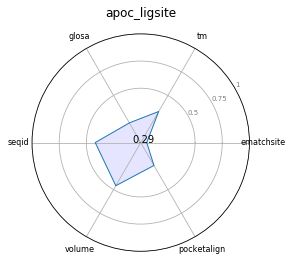

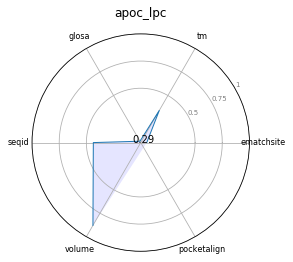

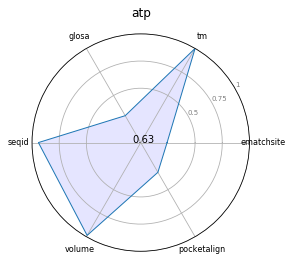

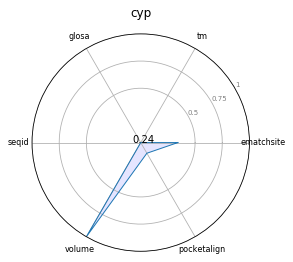

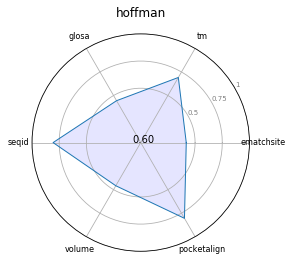

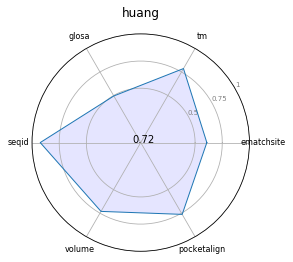

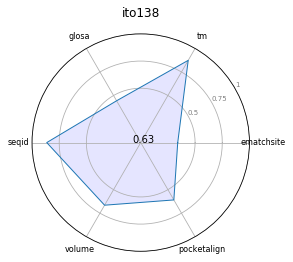

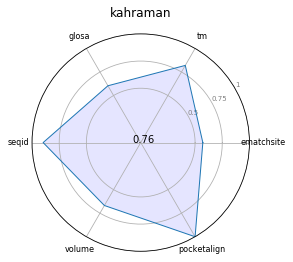

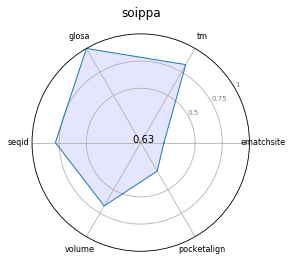

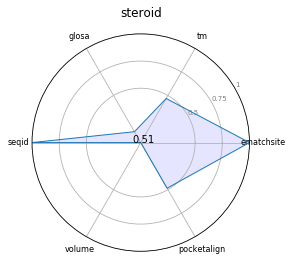

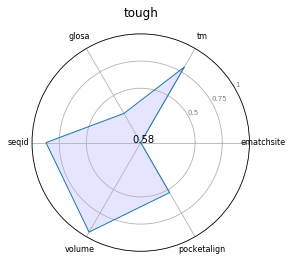

In [200]:

for dset in df_normalized.index:
    # 1 - df b/c we want datasets 
    spider(1-df_normalized, dset)




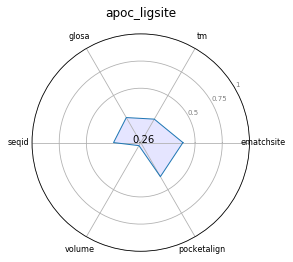

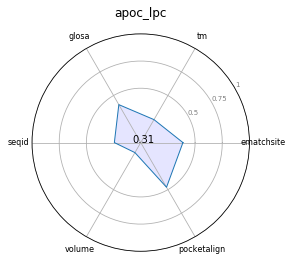

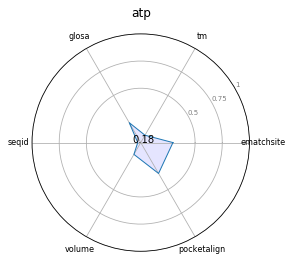

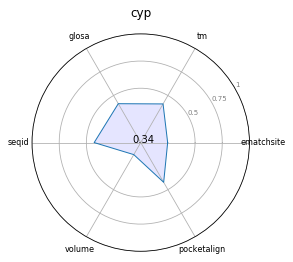

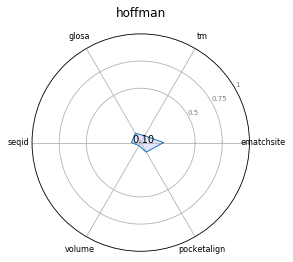

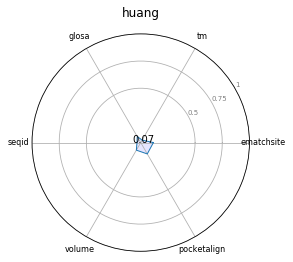

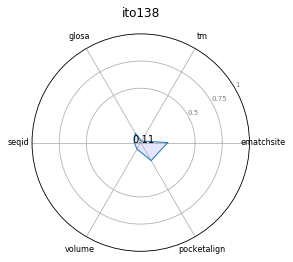

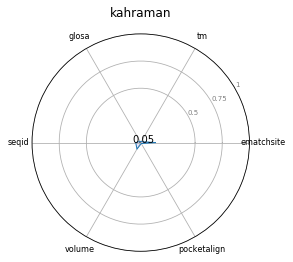

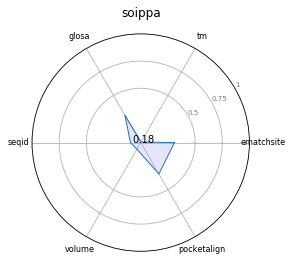

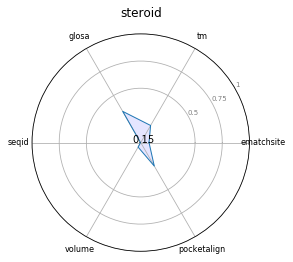

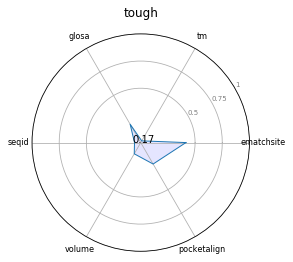

In [203]:
for dset in aucs_df.index:
    # 1 - df b/c we want datasets 
    spider(np.abs(aucs_df-0.5), dset)